# LLB parameter implementation

In [1]:
import numpy as np
from scipy import constants as sp
from scipy import optimize as op
from scipy import interpolate as ip
from matplotlib import pyplot as plt

## (Magnetic) material class

I define a class that should compute and hold all the relevant parameters needed for the LLB computation. This class holds only material-specific parameters, while interactions between different materials should be defined and imported from the Structure class.

In [2]:
class material():
    def __init__(self, name, S, Tc, lamda, muat, kappa_anis, K_0, A_0):
        self.name=name                                      # name of the material used for the string representation of the class
        self.S=S                                            # effective spin
        self.Tc=Tc                                          # Curie temperature
        self.J=3*self.S/(self.S+1)*sp.k*self.Tc             # mean field exchange coupling constant
        self.mean_mag_map=create_mean_mag_map(self)         # creates the mean magnetization map over temperature as an interpolation function
        self.brillouin_deriv=create_brillouin_deriv(self)     # creates the mean magnetization derivative of temperature as an interpolation function
        self.lamda=lamda                                    # intrinsic coupling to bath parameter
        self.muat=muat                                      # atomic magnetic moment
        self.kappa_anis=kappa_anis                          # exponent for the temperature dependence of uniaxial anisotropy
        self.K_0=K_0                                        # value for the anisotropy at T=0 K in units of J
        self.A_0=A_0                                        # value for the exchange stiffness at T=0 K in units of J*m^2

In [3]:
    def __str__(self):
        return self.name

### Creation of the mean magnetization map

Here a temperature map of the mean field magnetization $m_{eq}(T)$ is created.
This means solving the self consistent equation

\begin{eqnarray}
    m_{eq}(T)&=&B_S(m_{eq}, T) \label{meq_def} \\
    B_S(m, T)&=& \frac{2 S+1}{2S} \coth{(\frac{2S+1}{2S}\frac{\text{self.}Jm}{k_BT})}-\frac{1}{2S} \coth{(\frac{1}{2S} \frac{\text{self.}Jm}{k_B T})} \label{Brillouin},
\end{eqnarray}

where

\begin{align}
\text{self.}J=3\frac{S}{S+1}k_B \ \text{self.}T_C
\end{align}

is the mean field exchange coupling constant for effective spin self.$S$ and Curie temperature self.$T_C$

In [4]:
    def create_mean_mag_map(self):
        # This function computes the mean field mean magnetization map by solving the self-consistent equation m=B(m, T)
        # As an output we get an interpolation function of the mean field magnetization at any temperature T<=T_c (this can of course be extended to T>T_c with zeros).
        # I have not worried about m<0 yet but this should be a quick implementation by mirroring the interpolation function later on in the code.

        # Start by defining a unity function m=m:
        def mag(m):
            return m

        # Define the Brillouin function as a function of scalars, as fsolve takes functions of scalars:
        def Brillouin(m, T):
            # This function takes input parameters
            #   (i) magnetization amplitude m_amp_grid (scalar)
            #   (ii) (electron) temperature (scalar)
            # As an output we get the Brillouin function evaluated at (i), (ii) (scalar)

            eta = self.J * m / sp.k / T /self.Tc
            c1 = (2 * self.S + 1) / (2 * self.S)
            c2 = 1 / (2 * self.S)
            bri_func = c1 / np.tanh(c1 * eta) - c2 / np.tanh(c2 * eta)
            return bri_func

        # Then we also need a temperature grid. I'll make it course grained for low temperatures (<0.8*Tc) (small slope) and fine grained for large temperatures (large slope):
        temp_grid=np.array(list(np.arange(0, 0.8, 1e-3))+list(np.arange(0.8, 1+1e-5, 1e-5)))

        # I will define the list of m_eq(T) here and append the solutions of m=B(m, T). It will have the length len(temp_grid) at the end.
        meq_list=[1.]

        # Define a function to find the intersection of m and B(m, T) for given T with scipy:
        def find_intersection_sp(m, Bm, m0):
            return op.fsolve(lambda x: m(x) - Bm(x), m0)

        # Find meq for every temperature, starting point for the search being (1-T/Tc)^(1/2), fill the list
        for i,T in enumerate(temp_grid[1:]):
            # Redefine the Brillouin function to set the temperature parameter (I did not find a more elegant solution to this):
            def Brillouin_2(m):
                return Brillouin(m, T)
            # Get meq:
            meq=find_intersection_sp(mag, Brillouin_2, np.sqrt(1-T))
            if meq[0]<0:            # This is a comletely unwarranted fix for values of meq<0 at temperatures very close to Tc, that fsolve produces. It seems to work though, as the interpolated function plotted by plot_mean_mags() seems clean.
                meq[0]*=-1
            # Append it to list me(T)
            meq_list.append(meq[0])
        meq_list[-1]=0              # This fixes slight computational errors to fix m_eq(Tc)=0 (it produces something like m_eq[-1]=1e-7)
        return ip.interp1d(temp_grid, meq_list)

### Creation of the map of derivative of the Brillouin function

To later define the longitudinal suszeptibility, we need to define the derivative of the Brillouin function. To speed up the simulation, we also create a map thereof:

\begin{align}
\frac{dB}{dx} = \frac{1}{4S^2\sinh^2(x/2S)}-\frac{(2S+1)^2}{4S^2\sinh^2(\frac{(2S+1)x}{2S})}, 
\end{align}

where $x=\frac{Jm}{k_BT}$.

Thus we define a grid on the scale $x \in [0,50]$ and create an interpolation function of the equation on this grid.

In [5]:
    def create_brillouin_deriv(self):
        # This function returns the derivative of the Brillouin function, needed to compute the longitudinal susceptibility.
        etagrid=np.array(list(np.arange(0,20,1e-5))+list(np.arange(20,50,1e-3)))
        c1=(2*self.S+1)/2/self.S
        c2=1/2/self.S
        return ip.interp1d(etagrid, c2**2/(np.sinh(c2*etagrid))**2-c1**2/(np.sinh(c1*etagrid))**2)

### Calling the mean field magnetization and Brillouin derivative

In the __init()__ function, the maps of mean field magnetization and derivative of Brillouin function are called and saved with create_ functions. To call use these maps for any array of temperatures we define the get_ functions. 

In [6]:
    def get_mean_mag(self, T):
        # After creating the map, this function can be called to give m_eq at any temperature
        # The function takes a 1d-array of temperatures as an input (temperature map at each timestep) and returns an array with the respective mean field equilibrium temperatures
        tcmask=T<1.
        meq=np.zeros(len(T))
        meq[tcmask]=self.mean_mag_map(T[tcmask])
        return meq

In [7]:
    def get_brillouin_deriv(self):
        tcmask=T<1.
        dbri=np.zeros(len(T))
        dbri[tcmask]=self.brillouin_deriv(T[tcmask])
        return dbri

### Temperature dependent parameters

#### Transverse and longitudinal damping parameters

Here we define functions of temperature T that return the damping parameters of the LLB:

\begin{eqnarray}
\alpha_{\parallel} &=& \frac{2\lambda}{S+1}\frac{1}{\sinh(2q_s)}\\
\alpha_{\perp} &=& \frac{\lambda}{m_{eq}(T)}(\frac{\tanh(q_s)}{q_s}-\frac{T}{T_C}),
\end{eqnarray}

where

\begin{align}
q_s=\frac{3 T_C m_{eq}(T)}{(2S+1)T}
\end{align}

$m_{eq}(T)$ is an argument of the function as get_mean_mag() will be called at every timestep before calling the functions for temperature dependent parameters.

In [8]:
    def alpha_par(self, T, meq):
        # This funtion computes the longitudinal damping parameter alpha_parallel
        return 2*self.lamda/(self.S+1)*1/np.sinh(3*self.Tc*meq/(self.S+1)*T)

    def alpha_trans(self, T, meq):
        # This function computes the transverse damping parameter alpha_transverse
        qs=3*self.Tc*meq/(2*self.S+1)/T
        return self.lamda/meq*(np.tanh(qs)/qs-T/3/self.Tc)

#### Longitudinal Susceptibility

The longitudinal susceptibility in MFA is expressed as

\begin{align}
\chi_{\parallel}=\frac{\beta \mu_{\rm{at}} B_S'(m_{eq},T)}{1-\beta J B_S'(m_{eq}, T)}
\end{align}

In [9]:
    def chi_par(self, Bs_prime, T):
        return 1/sp.k/T*self.muat*Bs_prime/(1-1/sp.k/T*self.J*Bs_prime)

#### Uniaxial Anisotropy strength

The uniaxial anisotropy field along of grain i along the easy (m,n,o)-axis is expressed in the form.

\begin{align}
\mathbf{H}_{i,A_m}=-\frac{2 K_i(T)}{\mu_{at}} \frac{\left( m_{i,n}^2 + m_{i,o}^2 \right)}{m_i^2},
\end{align}

where $K_i(T)=K_0 \ m_{eq}(T)^{\kappa}$ scales in a power law with the equilibrium magnetization, $\kappa$ being a material parameter. Here, only the temperature-indipendent but material_dependent part of the prefactor is computed. This is done, so that later when the sample-structure und temperature profile are defined, the corresponding field for the whole sample can be computed with minimal computational effort (I hope and think so at least). What we thus do here is to compute

\begin{align}
    E_{0,anis}=\frac{2K_0}{\mu_{at}}
\end{align}

In [10]:
    def anisotropy(self, meq, m, m_amps, ax):
        #This takes mean field magnetization (1d-array of length N (number of grains)), magnetization vectors (dimension 3xN), magnetization amplitudes (length N) and easy axis ([0,1,2] corresponding to [x,y,z])
        mag_hard_ax_squared=np.sum(np.delete(m, ax, axis=0)**2, axis=0)
        return -2*self.K_0*meq**self.kappa_anis/self.muat*mag_hard_ax_squared/m_amps**2

#### Exchange stiffness

The exchange field is expressed by

\begin{align}
H_{i,ex}=\frac{2A(T)}{m_e^2 \Delta^2} \sum_{j \ neighb \ i} (m_j-m_i),
\end{align}

where $A(T)=A_0 m_{eq}(T)^2$ is the temperature dependent exchange stiffness and $\Delta$ is the dimension of the cubic magnetic grains. Again, we only compute the temperatureprefactor here. At this point there is nothing to compute here, this block serves only for documentation. \textcolor{red}{Whats the best way to define grain size in the code?}

## Creating some sample structure

Apart from defining all the necessary fields and material parameters, the most important part is to properly define the sample structure and simplify computation of the magnetic fields for any given sample. For this, we define a rather complicated sample-composition in the following function get_sample(), consisting of three different 'materials' (defined on the grainsize of the micromagnetic simulation, so some nm in thickness) with different magnetic properties and respective interface properties, that need to be defined in the following. Apart from only the sample-structure, we retrieve also the magnetization coordinates of every magnetic grain, and the positions (indices of the 1d array that defines the sample of magnetic grains) of each of the material. This will help to later call the functions within the material class on an array that contains all magnetic grains of each material.

Example: Sample consists of three materials in the following order:

\begin{align}
[mat1, mat2, mat3, mat3, mat1]
\end{align}

material_grain_indices is a list of M lists (M=number of different materials in the sample), with each of the M lists containing the indices of all positions of this material, so:

\begin{align}
\text{material_grain_indices}=[[0,4],[1],[2,3]]
\end{align}

material_grain_indices_flat is merely the flattened version of it, which can be used to reordering the computation results in the same order as the sample again.

In [11]:
def get_sample():
    # This is a dummy function that should definitely be replaced by outputs from your code. It does not take any input parameters as I define everything here.
    # As an output we get
    #   (i) a 1d list of M materials within the sample (materials on the scale of the grainsize of the macrospins)
    #   (ii) a 1d numpy array of the actual sample consisting of stacked layers of the M materials
    #   (iii-v) magnetization amplitudes and angles
    
    # Define define three dummy materials with different parameters:
    mat_1 = material('uno', 1/2, 650., 0.01, 2., 1.6, 1.5e6, 1e-3)
    mat_2 = material('dos', 7/2, 1200., 0.015, 1., 1.6, 1.7e6, 1e-3)
    mat_3 = material('tres', 1, 300., 0.02, 1.5, 1.6, 2.2e6, 1e-3)
    materials=[mat_1, mat_2, mat_3]

    # Define a sample structure where 5 layers of each material build blocks that are periodically stacked 10 times (5*3*10=150=N):
    building_block=np.concatenate((np.array([mat_1 for _ in range(5)]), np.array([mat_2 for _ in range(5)]), np.array([mat_3 for _ in range(5)])))
    sample=np.concatenate([building_block for _ in range(10)])
    
    #The following constructs a list of lists, containing in list[i] a list of indices of material i in the sample_structure. This will help compute the mean field magnetization only once for every material at each timestep. 
    material_grain_indices=[]
    for mat in materials:
        material_grain_indices.append([i for i in range(len(sample)) if sample[i]==mat])
    material_grain_indices_flat=[index for mat_list in material_grain_indices for index in mat_list]
    
    #The following list locates which material is positioned at which grain of the sample. THis will later be used to define an array of material paramters for the whole sample 
    mat_locator=[materials.index(grain) for grain in sample]

    #Define initial magnetization on the whole sample (for simplicity uniform) and fully magnetized along the z-axis
    m_amp = np.ones(150)
    m_phi = np.zeros(150)
    m_gamma = np.zeros(150)
    return materials, sample, m_amp, m_phi, m_gamma, material_grain_indices, material_grain_indices_flat, mat_locator

In [12]:
arr=[1,2,3,1,1]
grain_ind=[]
for num in range(1,4):
    grain_ind.append([i for i in range(len(arr)) if arr[i]==num])
print(grain_ind)

ind_flat=[item for sub_list in grain_ind for item in sub_list]
ind_order=[ind_flat[i] for i in ind_flat]
print(ind_order)

[[0, 3, 4], [1], [2]]
[0, 1, 2, 3, 4]


### Creating magnetization vectors

In [13]:
def get_mag(amp, gamma, phi):
    # This function takes as input parameters the amplitude and angles (A1, A2, A3) and puts out a numpy array of dimension 3xN
    # with 3 magnetization components for N grains

    mx=amp*np.cos(gamma)*np.sin(phi)
    my=amp*np.sin(gamma)*np.sin(phi)
    mz=amp*np.cos(phi)
    return(mx, my, mz)

### Plotting functions for the $m_{eq}(T)$ maps

This should really work for any sample preperation. Just to visualize the output of mean field magnetization for different parameters, being spin and critical temperature

In [14]:
def plot_mean_mags(materials, save=False):
    #define a temperature grid:
    temps=np.arange(0,2+1e-4, 1e-4)
    temps[-1]=1.
    for i,m in enumerate(materials):
        mmag=get_mean_mag(m, temps)
        label=str(m.name)
        plt.plot(temps*m.Tc, mmag, label=label)

    plt.xlabel(r'Temperature [K]', fontsize=16)
    plt.ylabel(r'$m_{\rm{eq}}$', fontsize=16)
    plt.legend(fontsize=14)
    if save:
        plt.title(r'$m_{\rm{eq}}$ for all materials in sample', fontsize=18)
    plt.savefig('plots/meqtest.pdf')
    plt.show()

In [15]:
def plot_mean_mag_derivs(materials, save=False):
    #define a temperature grid:
    temps=np.arange(0,2+1e-4, 1e-4)
    temps[-1]=1.
    for i,m in enumerate(materials):
        dTmmag=get_brillouin_deriv(m, temps)
        label=str(m.name)
        plt.plot(temps*m.Tc, dTmmag, label=label)

    plt.xlabel(r'Temperature [K]', fontsize=16)
    plt.ylabel(r'$\partial_Tm_{\rm{eq}}$ [1/K]', fontsize=16)
    plt.legend(fontsize=14)
    if save:
        plt.title(r'Derivative of $m_{\rm{eq}}$ for all materials in sample', fontsize=18)
    plt.savefig('plots/dmeqdTtest.pdf')
    plt.show()

In [16]:
materials, sample, m_amp, m_phi, m_gamma, mat_gr_ind, mat_gr_ind_flat, mat_loc=get_sample()
print(mat_loc)

C:\Users\Theodor Griepe\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Theodor Griepe\AppData\Local\Temp\ipykernel_6396\3347895553.py:6: RuntimeWarning: divide by zero encountered in divide
  return ip.interp1d(etagrid, c2**2/(np.sinh(c2*etagrid))**2-c1**2/(np.sinh(c1*etagrid))**2)
C:\Users\Theodor Griepe\AppData\Local\Temp\ipykernel_6396\3347895553.py:6: RuntimeWarning: invalid value encountered in subtract
  return ip.interp1d(etagrid, c2**2/(np.sinh(c2*etagrid))**2-c1**2/(np.sinh(c1*etagrid))**2)


[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]


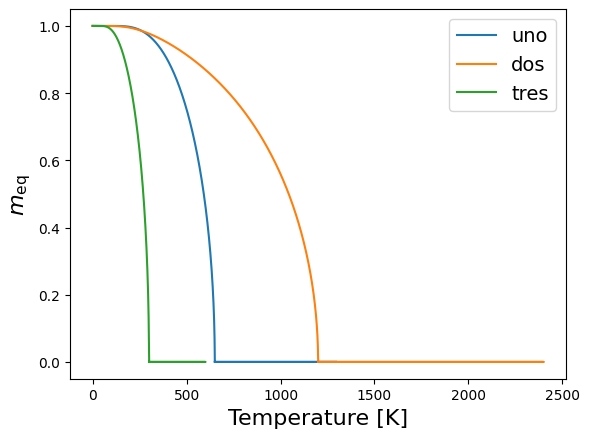

In [17]:
plot_mean_mags(materials)

## Functions applied on the complete sample structure before the dynamical simulation

### Matrix of coupling constants an construction of exchange (coupling and stiffness) array

The follwoing peace of code defines a symmetric matrix of dimension len(materials)xlen(materials) (here three, indices a,b,c) between potential neighbouring grains with indices i,j

\begin{align}
    \mathcal{J}_{ij}= \left( \begin{matrix}J_{aa} \ J_{ab} \ J_{ac} \\ J_{ba} \ J_{bb} \ J_{cb} \\ J_{ca} \ J_{cb} \ J_{cc}\end{matrix} \right),
\end{align}

where $J_{lk}=J_{kl}$ for $k,l \in [a,b,c]$ 
and $J_{ll}=3 \frac{l.S}{l.S+1} k_B \ l.T_C$ is just the mean field exchange coupling constant for material $l$.

Now one can fill the array exch_coup_arr with the respective coupling constants of neighbouring grains as defined in sample. 
For a sample of five grains

$[mat1, mat2, mat3, mat3, mat1]$

this would produce

$[[0, J_{12}],[J_{21}, J_{23}],[J_{32}, J_{33}],[J_{33}, J_{31}],[J_{31}, 0]]$

This function just needs to be called once to create the proper interaction array for the simulated sample.

In [18]:
def get_exch_coup_sam(materials, sample, mat_loc):
    # This function takes as input parameters:
    #   (i) the 1d-list of magnetic unique materials in the sample (size M)
    #   (ii) the 1d numpy array of the sample, consisting of a material (from class material) at each grain (size N)
    # As an output we get a 2d numpy array of dimension Nx2 for coupling each site with its 2 neighbours in the linear chain of grains.

    # Define a matrix J_mat of dimension len(materials)xlen(materials) with the exchange coupling constants of mat_i and mat_j at J_mat[i][j]=J_mat[j][i]
    J_mat=np.zeros((len(materials), len(materials)))
    # fill the diagonal with the mean field exchange constant of each material:
    for i, mat in enumerate(materials):
        J_mat[i][i]=mat.J
    # define the off-diagonals, namely some values for exchange coupling constants of different materials:
    J_mat[0][1]=1e-20
    J_mat[1][2]=5e-20
    J_mat[0][2]=1e-19
    # symmetrize the matrix so that also elements [i][j] with i>j can be read out:
    for i in range(1,len(materials)):
        for j in range(i):
            J_mat[i][j]=J_mat[j][i]

    # Now we can assign the coupling of each grain to its nearest neighbours by filling the output array with the respective matrix entry:
    # Let's define the output array:
    ex_coup_arr=np.zeros((len(sample),2))
    
    # This list can assign the proper matrix elements to the output matrix
    for i, grain in enumerate(sample):
        if i>0:
            ex_coup_arr[i][0]=J_mat[mat_loc[i]][mat_loc[i-1]]
        if i<len(sample)-1:
            ex_coup_arr[i][1]=J_mat[mat_loc[i]][mat_loc[i+1]]
    return ex_coup_arr

In [22]:
exch_coup_const_sam=get_exch_coup_sam(materials, sample, mat_loc)
print(exch_coup_const_sam)

[[0.0000000e+00 8.9742185e-21]
 [8.9742185e-21 8.9742185e-21]
 [8.9742185e-21 8.9742185e-21]
 [8.9742185e-21 8.9742185e-21]
 [8.9742185e-21 1.0000000e-20]
 [1.0000000e-20 3.8658172e-20]
 [3.8658172e-20 3.8658172e-20]
 [3.8658172e-20 3.8658172e-20]
 [3.8658172e-20 3.8658172e-20]
 [3.8658172e-20 5.0000000e-20]
 [5.0000000e-20 6.2129205e-21]
 [6.2129205e-21 6.2129205e-21]
 [6.2129205e-21 6.2129205e-21]
 [6.2129205e-21 6.2129205e-21]
 [6.2129205e-21 1.0000000e-19]
 [1.0000000e-19 8.9742185e-21]
 [8.9742185e-21 8.9742185e-21]
 [8.9742185e-21 8.9742185e-21]
 [8.9742185e-21 8.9742185e-21]
 [8.9742185e-21 1.0000000e-20]
 [1.0000000e-20 3.8658172e-20]
 [3.8658172e-20 3.8658172e-20]
 [3.8658172e-20 3.8658172e-20]
 [3.8658172e-20 3.8658172e-20]
 [3.8658172e-20 5.0000000e-20]
 [5.0000000e-20 6.2129205e-21]
 [6.2129205e-21 6.2129205e-21]
 [6.2129205e-21 6.2129205e-21]
 [6.2129205e-21 6.2129205e-21]
 [6.2129205e-21 1.0000000e-19]
 [1.0000000e-19 8.9742185e-21]
 [8.9742185e-21 8.9742185e-21]
 [8.9742

In [ ]:
def get_exch_stiff_sam(materials, sample, mat_loc):
    #This computes a grid for the exchange stiffness in analogous fashion to get_exch_coup_sam()
    A_mat=np.zeros((len(materials), len(materials)))
    for i, mat in enumerate(materials):
        A_mat[i][i]=mat.A_0
        
    A_mat[0][1]=1e-12
    A_mat[1][2]=5e-12
    A_mat[0][2]=2.5e-12
    
    for i in range(1, len(materials)):
        for j in range(i):
            A_mat[i][j]=A_mat[j][i]
            
    ex_stiff_arr=np.zeros((len(sample),2))
    
    for i, grain in enumerate(sample):
        if i>0:
            ex_stiff_arr[i][0]=A_mat[mat_loc[i]][mat_loc[i-1]]
        if i<len(sample)-1:
            ex_stiff_arr[i][1]=A_mat[mat_loc[i]][mat_loc[i+1]]
    return ex_stiff_arr

In [ ]:
ex_stiff_sam=get_exch_stiff_sam(materials, sample, mat_loc)
print(ex_stiff_sam)

### Anisotropy strenghts

In [27]:
def get_ani_sam(materials, mat_loc):
    ani_arr=[anisotropy(materials[i]) for i in mat_loc]
    return ani_arr

In [28]:
anis_const_sam=get_ani_sam(materials, mat_loc)

TypeError: anisotropy() missing 4 required positional arguments: 'meq', 'm', 'm_amps', and 'ax'

# LLB 1d dynamical simulation

## Overview of dynamical simulation

Now comes the actual dynamical qLLB simulation. We will import a temperature profile dependent on time and 1d-space, and evaluate the change of magnetization vectors of every grain within the sample at every timestep. The dynamical LLB equations are expressed as follows:

\begin{align}
    \frac{1}{\gamma}\frac{d\mathbf{m}}{dt}=\mathbf{m} \times \mathbf{H}_{eff}+ \frac{\alpha_{\perp}}{m^2}\mathbf{m} \times (\mathbf{m} \times \mathbf{H}_{eff}) + \frac{\alpha_{\parallel}}{m^2} (\mathbf{m}  \cdot \mathbf{H}_{eff}) \cdot \mathbf{m},
\end{align}

with the above defined damping parameters. The three terms describe i) precession at Lamor frequency, ii) transversal damping (conserving the macrospin length) and iii) longitudinal damping (changing macrospin length due to incoherent atomistic spin excitations within the grainsize the macrospin is defined on). The effective magnetic field is the sum of all relevant magnetic interactions:

\begin{align}
    \mathbf{H}_{eff}= \mathbf{H}_{ext}+\mathbf{H}_A+\mathbf{H}_{ex}+\mathbf{H}_{th},
\end{align}

where $\mathbf{H}_{ext}$ is an external magnetic field, and $\mathbf{H}_{th}$ is a thermal field, defined as:

\begin{align}
    \mathbf{H}_{th}=_{T<T_C} \frac{1}{2\chi_{\parallel}}(1-\frac{m^2}{m_e^2})\mathbf{m}
\end{align}

\begin{align}
    \mathbf{H}_{th}=_{T>T_C} \frac{1}{\chi_{\parallel}}(1+\frac{3}{5} \frac{T_C}{T-T_C}m^2)\mathbf{m}
\end{align}

## Functions that are to be computed at every timestep

are all temperature dependent functions. Expecially the mean field magnetization profile for the sample at a given temperature profile, and the corresponding effective magnetic field.

### Profile of the mean field magnetization

Now we make use of the material-specific seperation of the sample in terms of mat_gr_ind and construct a mean mag map for a given array of temperatures and an arbitrary sample composition.

In [ ]:
def get_mean_mag_sam(mat_gr_ind, materials, T):
    #T shall be a list of lists ordered the same way as material_grain_indices. Later on we will construct such a temperature list from 1d- input data.